In [1]:
import pandas as pd
import lib
import matplotlib.pyplot as plt

In [2]:
geosra_pd = pd.read_parquet('../data/raw/geo-sra-ecological.parquet.gzip')
print(geosra_pd["organism"].head())

1836    wastewater metagenome
1932    wastewater metagenome
2497       biofilm metagenome
2503      seawater metagenome
2637      sediment metagenome
Name: organism, dtype: string


In [3]:
# Extract the dictionary
count  = dict(geosra_pd["organism"].value_counts())
print(count)

{'soil metagenome': 49532, 'wastewater metagenome': 43834, 'marine metagenome': 20346, 'freshwater metagenome': 9364, 'sediment metagenome': 9327, 'rhizosphere metagenome': 5369, 'seawater metagenome': 5366, 'aquatic metagenome': 4038, 'air metagenome': 3561, 'food metagenome': 3346, 'marine sediment metagenome': 2654, 'activated sludge metagenome': 2505, 'bioreactor metagenome': 2476, 'clinical metagenome': 2469, 'lake water metagenome': 2315, 'dust metagenome': 2253, 'biofilm metagenome': 2186, 'freshwater sediment metagenome': 1878, 'food fermentation metagenome': 1530, 'peat metagenome': 1478, 'sludge metagenome': 1400, 'urban metagenome': 1251, 'anaerobic digester metagenome': 1196, 'indoor metagenome': 1196, 'groundwater metagenome': 1183, 'estuary metagenome': 1140, 'marine plankton metagenome': 1099, 'microbial mat metagenome': 979, 'fermentation metagenome': 961, 'compost metagenome': 924, 'glacier metagenome': 903, 'wetland metagenome': 899, 'hot springs metagenome': 838, 'dr

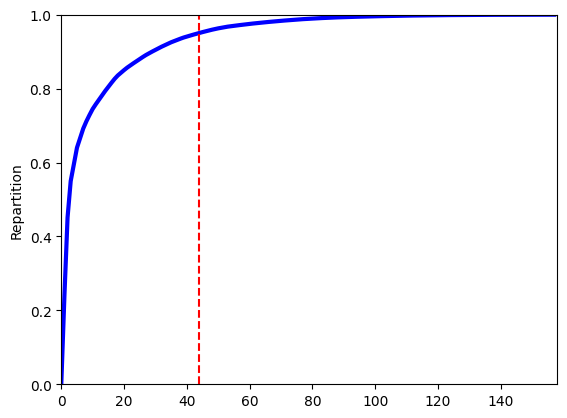

In [4]:
# Repartition function
repa,thr = lib.repartition(count)

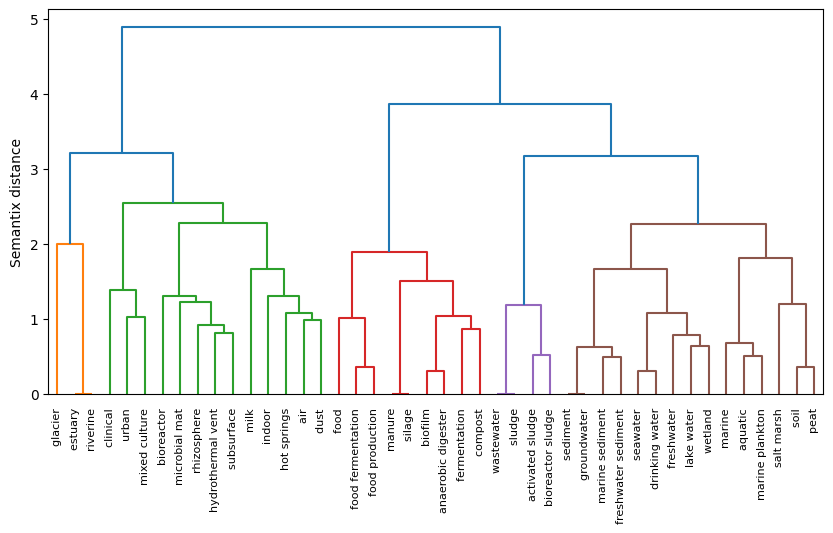

In [5]:
# Dendogram (semantix)
chains = list(count.keys())[:thr]
chains = [chain.replace('metagenome', '') for chain in chains]
dend = lib.semantix_dendogram(chains)

In [6]:
# Dictionary shelves : cluster
shelves = [dend['ivl'][i]+'metagenome' for i in range(len(dend['ivl']))]
class_dict = dict(zip(shelves,dend['leaves_color_list']))

# List of classes (clusters)
class_list = []
for shelve in shelves:
    classe = class_dict[shelve]
    if classe not in class_list:
        class_list.append(classe)
class_list.append('NC')

# Count of classes (clusters)
class_count = [0]*len(class_list)
for i in range(len(class_list)):
    classe = class_list[i]
    for shelve in shelves:
        if classe == class_dict[shelve]:
            class_count[i] += count[shelve]
class_count[len(class_count)-1] = sum(count.values()) - sum(class_count)

# Dictionary cluster : count
count_dict = dict(zip(class_list,class_count))
print(count_dict)

{'C1': 2737, 'C2': 22924, 'C3': 11791, 'C4': 48264, 'C5': 110919, 'NC': 10214}


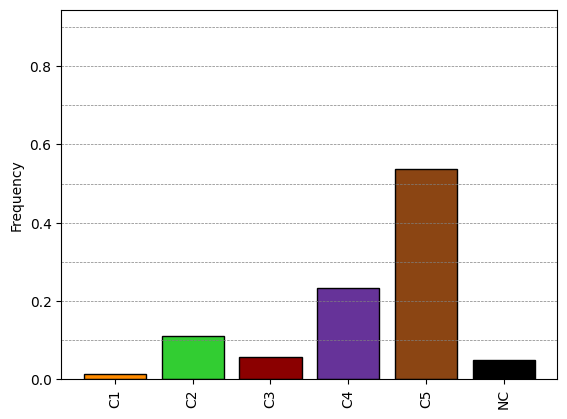

In [7]:
# Histogramm of the clusters
colors = ["darkorange","limegreen","darkred","rebeccapurple","saddlebrown","black"]
lib.norm_hist(count_dict,colors=colors)

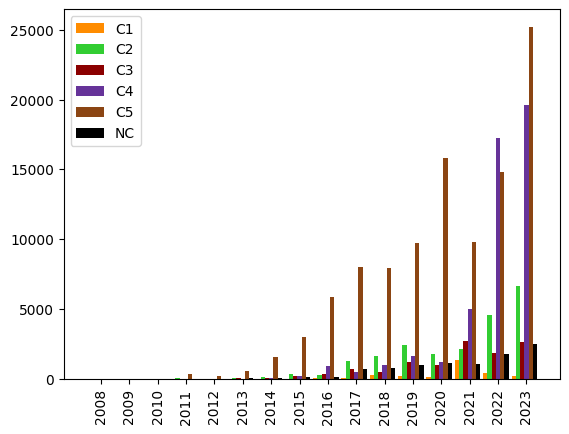

In [8]:
geosra_pd["cluster_class"] = geosra_pd["organism"].map(class_dict)
geosra_pd["cluster_class"] = geosra_pd["cluster_class"].fillna("NC")
geosra_pd["release_year"] = geosra_pd["releasedate"].dt.year
datas = []
for year in range(2008,2024):
    data_year = dict(geosra_pd[geosra_pd["release_year"] == year]["cluster_class"].value_counts())
    for cluster in class_list:
        if not cluster in data_year:
            data_year[cluster] = 0.0 
    data_year = dict(sorted(data_year.items()))
    datas.append(data_year)
df = pd.DataFrame(datas,index=[year for year in range(2008,2024)])
colors = ["darkorange","limegreen","darkred","rebeccapurple","saddlebrown","black"]
lib.hist(df, width_bar=0.15, colors=colors)

In [9]:
geosra_pd.to_parquet("../data/processed/geosra_clusters.parquet.gzip")